# AB InBev Beer Challenge

## Configuración y funciones a utilizar

In [1]:
from utils import *
from sklearn.metrics.pairwise import cosine_similarity
from functools import reduce

## Extracción de los datos

In [2]:
# Read the csv files of the atributes
file_path_atributes = "../data/raw/atributos.csv"
atributes = read_csv_with_lowercase_columns(file_path_atributes)
categorical = ["bussinesssegment","concentracion","nse","segmentounico","canal"]
numerical = ["totalvolumen","skudistintospromediosxorden","skudistintostotales"]
# Read the csv files of the transactions
file_path_transactions = "../data/raw/transacciones.csv"
transactions = read_csv_with_lowercase_columns(file_path_transactions)
# Display the first rows of the DataFrame of the transactions
print(transactions.head())

shape: (5, 6)
┌─────┬────────────┬────────┬──────────────┬───────────────┬──────────────────┐
│ id  ┆ account_id ┆ sku_id ┆ invoice_date ┆ order_id      ┆ items_phys_cases │
│ --- ┆ ---        ┆ ---    ┆ ---          ┆ ---           ┆ ---              │
│ i64 ┆ i64        ┆ i64    ┆ i64          ┆ str           ┆ f64              │
╞═════╪════════════╪════════╪══════════════╪═══════════════╪══════════════════╡
│ 0   ┆ 430606     ┆ 7038   ┆ 20220729     ┆ 512-3880249-0 ┆ 100.0            │
│ 1   ┆ 323267     ┆ 14933  ┆ 20220729     ┆ 512-3882307-0 ┆ 1.0              │
│ 2   ┆ 357825     ┆ 21971  ┆ 20220723     ┆ 512-3852880-0 ┆ 8.0              │
│ 3   ┆ 444926     ┆ 7038   ┆ 20220805     ┆ 512-3913163-0 ┆ 20.0             │
│ 4   ┆ 450771     ┆ 7030   ┆ 20220816     ┆ 512-3957000-0 ┆ 5.0              │
└─────┴────────────┴────────┴──────────────┴───────────────┴──────────────────┘


In [3]:
# Display the first rows of the DataFrame of the atribues
atributes.head()

id,poc,bussinesssegment,totalvolumen,skudistintospromediosxorden,skudistintostotales,concentracion,nse,segmentounico,canal
i64,i64,str,f64,f64,i64,str,str,str,str
10,175519,"""HighUsage""",5.18752,4.1,16,"""Medio""","""Bajo""","""4.Activos""","""Kioscos/Maxikioscos"""
13,28533,"""HighUsage""",4.76866,3.9211,34,"""Alto""","""Medio""","""4.Activos""","""Tradicional"""
19,32182,"""PowerUsage""",5.9793,6.75,34,"""Alto""","""Medio""","""4.Activos""","""Tradicional"""
20,327976,"""MinimalUsage""",6.02852,3.5833,14,"""Alto""","""Medio""","""4.Activos""","""COMIDA"""
24,354640,"""PowerUsage""",7.525,3.2,18,"""Bajo""","""S/D""","""4.Activos""","""Tradicional"""


## Preprocesamiento necesario para EDA

En las los atributos:

* Calidad de los datos:
    * Revisar valores nulos
    * Revisar valores fuera de rango
    * Cuantificar outliers

En las transacciones:

* Calidad de los datos:
    *Revisar valores nulos
    * Revisar valores fuera de rango
    * Cuantificar outliers

Transformaciones y/o agregaciones:

* Convertir invoice_date a un formato de fecha: Aunque actualmente es un entero,convertiremos la variable invoice_date a un tipo de dato de fecha para realizar análisis temporales.

* Crear dataset aparte con agrupación por cliente: Dado que estamos interesados en el comportamiento de compra de los clientes, vamos a agrupar los datos por account_id para analizar patrones de compra individuales.

* Crear dataset aparte con agrupación por item: Dado que también estamos interesados en el comportamiento de compra sobre los items, vamos a agrupar los datos por sku_id para analizar patrones de compra que se dan en general para los items.


### Datos de atributos de los clientes

#### Calidad de los datos:
* Revisar valores nulos 
* Revisar valores fuera de rango
* Cuantificar outliers

##### **Análsis de valores nulos**

* Al notar que las distribuciones del dataset de no nulos es distinta, analizamos la relación entre las variables categóricas en cuestion: nse, concentracion, segmento unico y canal donde validamos que no son independientes entre si. Dado esto y que por su definición los efectos del NSE en latinoamerica normalmente están contenidos la cantidad de comercios en la zona debido a la segregación de las ciudades, es que hemos decidido eliminar la columna del NSE para no alterar las distribuciones de las métricas de interés.

* Con respecto al resto de los valores nulos, sumados corresponden al 8.8% de los datos y podemos notar que no generan un cambio en la distribución de las métricas de interés cuando eliminamos sus filas. Sin embargo, al analizar quienes son los clientes que hay en los valores nulos, podemos notar que solo un 20% es de bajo poder de compra y que dentro de los que tienen poco uso de la plataforma, hay varios con un potencial bueno de compra para el negocio por lo que se decide no hacer la eliminación de clientes.

* Un proxy de la concentración deberían ser las métricas de venta y las otras categorías, por lo que imputamos los valores faltantes de las variables categóricas concentración, segmento único y canal utilizando dichas variables explicativas

In [4]:
# Reemplazar "S/D" por nulos en las columnas "nse" y "concentración"
atributes = replace_sd_with_null(atributes, ["nse", "concentracion"])
# Revisar valores nulos en el DataFrame
null_values_df = check_null_values(atributes)
# Mostrar el resultado
print(null_values_df)
atributes[numerical].describe()

shape: (10, 3)
┌─────────────────────────────┬────────────┬─────────────────┐
│ column                      ┆ null_count ┆ null_percentage │
│ ---                         ┆ ---        ┆ ---             │
│ str                         ┆ u32        ┆ f64             │
╞═════════════════════════════╪════════════╪═════════════════╡
│ id                          ┆ 0          ┆ 0.0             │
│ poc                         ┆ 0          ┆ 0.0             │
│ bussinesssegment            ┆ 0          ┆ 0.0             │
│ totalvolumen                ┆ 0          ┆ 0.0             │
│ skudistintospromediosxorden ┆ 0          ┆ 0.0             │
│ skudistintostotales         ┆ 0          ┆ 0.0             │
│ concentracion               ┆ 326        ┆ 7.409091        │
│ nse                         ┆ 1023       ┆ 23.25           │
│ segmentounico               ┆ 75         ┆ 1.704545        │
│ canal                       ┆ 14         ┆ 0.318182        │
└─────────────────────────────┴─────────

statistic,totalvolumen,skudistintospromediosxorden,skudistintostotales
str,f64,f64,f64
"""count""",4400.0,4400.0,4400.0
"""null_count""",0.0,0.0,0.0
"""mean""",22.272537,5.911031,27.832727
"""std""",106.642437,3.227491,21.640289
"""min""",0.02124,0.7027,1.0
"""25%""",2.12124,3.6667,12.0
"""50%""",5.6011,5.1429,22.0
"""75%""",13.95536,7.3542,38.0
"""max""",4274.44416,33.0,157.0


##### NSE

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 1075.0       ┆ 1075.0                      ┆ 1075.0              │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 26.813149    ┆ 6.182723                    ┆ 25.525581           │
│ std        ┆ 114.105641   ┆ 3.501458                    ┆ 19.875404           │
│ min        ┆ 0.02508      ┆ 0.75                        ┆ 1.0                 │
│ 25%        ┆ 1.82192      ┆ 3.8333                      ┆ 11.0                │
│ 50%        ┆ 4.8178       ┆ 5.5                         ┆ 20.0                │
│ 

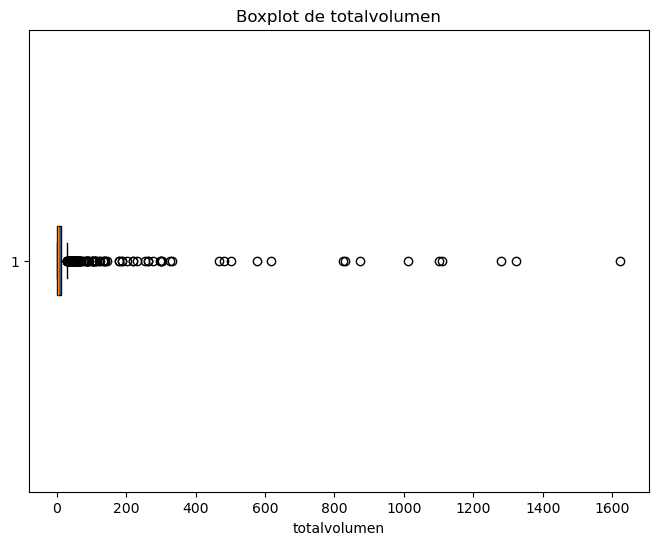

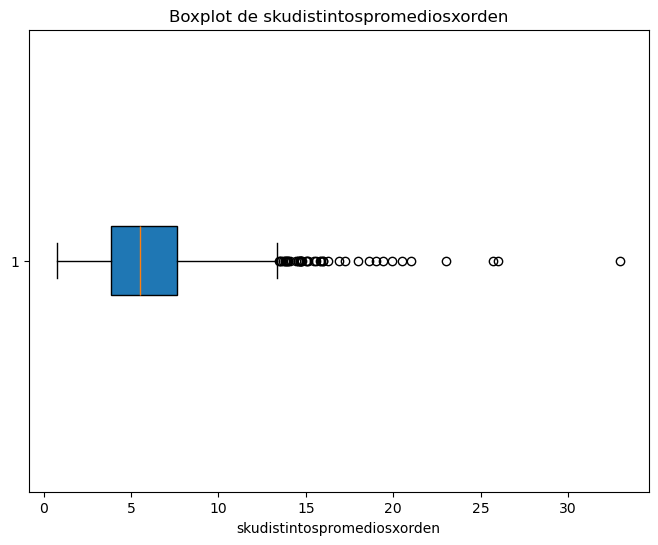

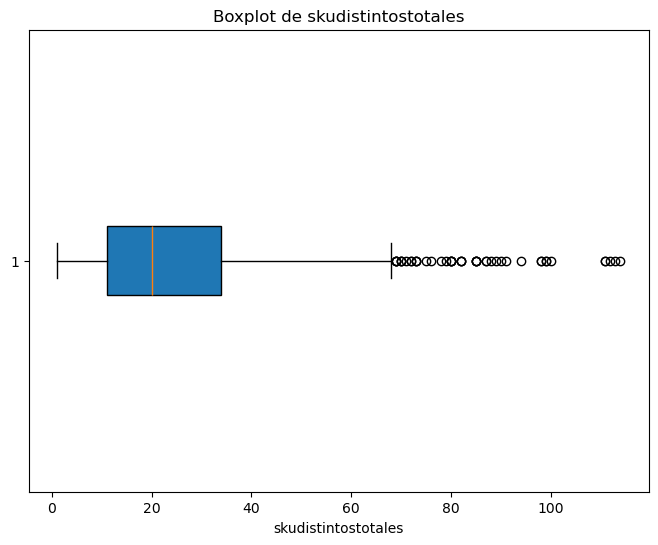

In [5]:
# filtramos los nulos
df_with_nulls = filter_rows_with_nulls(atributes)
# Mostrar las características de los valores nulos
print(df_with_nulls[numerical].describe())
plot_boxplots(df_with_nulls,numerical)

In [6]:
chi2_matrix(chi2_test, atributes, categorical, confidence_level=0.99)

,bussinesssegment,concentracion,nse,segmentounico,canal
bussinesssegment,False,True,True,True,True
concentracion,True,False,True,True,True
nse,True,True,False,True,True
segmentounico,True,True,True,False,True
canal,True,True,True,True,False


In [7]:
categorical = ["bussinesssegment","concentracion","segmentounico","canal"]
# Eliminar la columna "nse" del DataFrame
atributes = atributes.drop("nse")
print(check_null_values(atributes))
atributes.shape

shape: (9, 3)
┌─────────────────────────────┬────────────┬─────────────────┐
│ column                      ┆ null_count ┆ null_percentage │
│ ---                         ┆ ---        ┆ ---             │
│ str                         ┆ u32        ┆ f64             │
╞═════════════════════════════╪════════════╪═════════════════╡
│ id                          ┆ 0          ┆ 0.0             │
│ poc                         ┆ 0          ┆ 0.0             │
│ bussinesssegment            ┆ 0          ┆ 0.0             │
│ totalvolumen                ┆ 0          ┆ 0.0             │
│ skudistintospromediosxorden ┆ 0          ┆ 0.0             │
│ skudistintostotales         ┆ 0          ┆ 0.0             │
│ concentracion               ┆ 326        ┆ 7.409091        │
│ segmentounico               ┆ 75         ┆ 1.704545        │
│ canal                       ┆ 14         ┆ 0.318182        │
└─────────────────────────────┴────────────┴─────────────────┘


(4400, 9)

##### Imputación de valores nulos

* Para las variables concentración, canal y segmento único haremos imputación de datos

* Usamo un modelo de regresión logística ordenada para entender la significancia estádistica e impacto de las variables numéricas en la cateogoría target

* Luego, usamos las variables numéricas relevantes y las otras variables categóricas para imputar los valores faltantes de concentración, segmento único y canal utilizado, usando el algoritmo de Random Forest. El F1-score en datos de test del modelo que se usa para imputar da 0.53, 0.61 y 0.57, respectivamente

In [8]:
# Filter the original DataFrame to keep only rows without null values
df_without_nulls = filter_rows_without_nulls(atributes)
print(df_without_nulls[numerical].describe())

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 4011.0       ┆ 4011.0                      ┆ 4011.0              │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 21.644617    ┆ 5.81108                     ┆ 28.328596           │
│ std        ┆ 104.005686   ┆ 3.109883                    ┆ 21.90761            │
│ min        ┆ 0.02124      ┆ 0.7027                      ┆ 1.0                 │
│ 25%        ┆ 2.20068      ┆ 3.625                       ┆ 12.0                │
│ 50%        ┆ 5.7351       ┆ 5.0                         ┆ 22.0                │
│ 

In [9]:
count_distinct_grouped_by(df_with_nulls, y_column="poc", x_columns=["segmentounico"],z_columns=["poc_percentage"])

segmentounico,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""4.Activos""",400,1075,37.209302
"""1.Inactivos""",218,1075,20.27907
"""2.Masivos""",204,1075,18.976744
"""5.Select""",144,1075,13.395349
null,75,1075,6.976744
"""3.Potenciales""",34,1075,3.162791


In [10]:
count_distinct_grouped_by(df_with_nulls, y_column="poc", x_columns=["segmentounico","bussinesssegment"],z_columns=["segmentounico","bussinesssegment"])

segmentounico,bussinesssegment,poc_distinct_count,total_first_column,poc_percentage
str,str,u32,u32,f64
"""5.Select""","""PowerUsage""",89,144,61.805556
"""5.Select""","""HighUsage""",55,144,38.194444
"""4.Activos""","""PowerUsage""",124,400,31.0
"""4.Activos""","""MinimalUsage""",46,400,11.5
"""4.Activos""","""MediumUsage""",111,400,27.75
"""4.Activos""","""HighUsage""",119,400,29.75
"""3.Potenciales""","""PowerUsage""",2,34,5.882353
"""3.Potenciales""","""MinimalUsage""",14,34,41.176471
"""3.Potenciales""","""MediumUsage""",13,34,38.235294


In [11]:
grouped_stats = group_and_describe_with_percentiles(atributes, group_by_col="concentracion", numeric_cols=numerical)
# Mostrar el resultado
grouped_stats

concentracion,totalvolumen_mean,skudistintospromediosxorden_mean,skudistintostotales_mean,totalvolumen_median,skudistintospromediosxorden_median,skudistintostotales_median,totalvolumen_std_dev,skudistintospromediosxorden_std_dev,skudistintostotales_std_dev,totalvolumen_p25,totalvolumen_p50,totalvolumen_p75,skudistintospromediosxorden_p25,skudistintospromediosxorden_p50,skudistintospromediosxorden_p75,skudistintostotales_p25,skudistintostotales_p50,skudistintostotales_p75
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
null,30.789083,6.993971,23.47546,3.78565,6.09545,18.5,141.865463,4.189766,18.585296,1.57647,3.7899,9.7266,4.0,6.1,8.6,10.0,19.0,30.0
"""Alto""",18.804491,6.399199,30.996235,5.8368,5.6667,25.0,71.175366,3.335716,23.364124,2.10108,5.8368,14.83002,4.0,5.6667,8.0,13.0,25.0,43.0
"""Bajo""",19.574721,5.048585,22.691057,5.81728,4.4,15.0,71.709612,2.530654,21.005905,2.32184,5.81728,13.63538,3.1667,4.4,6.5,10.0,15.0,31.0
"""Medio""",24.969709,5.207682,25.275465,5.643,4.5651,20.0,132.492316,2.751772,19.470616,2.29594,5.64928,13.7368,3.3333,4.5714,6.3333,11.0,20.0,34.0


In [12]:
# Ejemplo de uso:
result = fit_ordered_logistic_regression(df_without_nulls, 'concentracion', numerical)
result.summary()

Optimization terminated successfully.
         Current function value: 0.781970
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                encoded   Log-Likelihood:                -3136.5
Model:                   OrderedModel   AIC:                             6283.
Method:            Maximum Likelihood   BIC:                             6314.
Date:                Wed, 14 Aug 2024                                         
Time:                        13:17:31                                         
No. Observations:                4011                                         
Df Residuals:                    4006                                         
Df Model:                           3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
totalvolumen                    0.0006      0.000      1.486      0.137      -0.000       0.001
skudistintospromediosxorden    -0.1246      0.014     -8.633      0.000      -0.153      -0.096
skudistintostotales            -0.0023      0.002     -1.156      0.248      -0.006       0.002
0/1                            -0.6794      0.072     -9.472      0.000      -0.820      -0.539
1/2                            -2.1040      0.091    -23.086      0.000      -2.283      -1.925
===============================================================================================
"""

In [13]:
# Ejemplo de uso:
atributes_updated ,cf_report, accuracy, cross_val_mean= fill_missing_values(atributes, 'concentracion', ['skudistintostotales'], ['bussinesssegment', 'segmentounico', 'canal'])
# Evaluar el modelo
print(cf_report)
print("Accuracy:", accuracy)
print("Cross-validation mean score:", cross_val_mean)
# Mostrar las primeras filas del DataFrame actualizado
check_null_values(atributes_updated)

              precision    recall  f1-score   support

        Alto       0.58      0.55      0.57       427
        Bajo       0.09      0.03      0.05        29
       Medio       0.49      0.55      0.52       359

    accuracy                           0.53       815
   macro avg       0.39      0.38      0.38       815
weighted avg       0.53      0.53      0.53       815

Accuracy: 0.5325153374233129
Cross-validation mean score: 0.5256156173136185


column,null_count,null_percentage
str,u32,f64
"""id""",0,0.0
"""poc""",0,0.0
"""bussinesssegment""",0,0.0
"""totalvolumen""",0,0.0
"""skudistintospromediosxorden""",0,0.0
"""skudistintostotales""",0,0.0
"""concentracion""",0,0.0
"""segmentounico""",75,1.704545
"""canal""",14,0.318182


In [14]:
# Ejemplo de uso:
result = fit_ordered_logistic_regression(df_without_nulls, 'segmentounico', numerical)
result.summary()

Optimization terminated successfully.
         Current function value: 1.177408
         Iterations: 27
         Function evaluations: 32
         Gradient evaluations: 32


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                encoded   Log-Likelihood:                -4722.6
Model:                   OrderedModel   AIC:                             9459.
Method:            Maximum Likelihood   BIC:                             9503.
Date:                Wed, 14 Aug 2024                                         
Time:                        13:17:32                                         
No. Observations:                4011                                         
Df Residuals:                    4004                                         
Df Model:                           3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
totalvolumen                    0.0044      0.001      6.374      0.000       0.003       0.006
skudistintospromediosxorden    -0.1253      0.013     -9.892      0.000      -0.150      -0.100
skudistintostotales             0.0690      0.002     29.609      0.000       0.064       0.074
0/1                            -0.5033      0.068     -7.402      0.000      -0.637      -0.370
1/2                             0.0757      0.034      2.199      0.028       0.008       0.143
2/3                            -1.9356      0.094    -20.528      0.000      -2.120      -1.751
3/4                             1.0603      0.023     46.715      0.000       1.016       1.105
===============================================================================================
"""

In [15]:
# Ejemplo de uso:
atributes_updated ,cf_report, accuracy, cross_val_mean= fill_missing_values(atributes_updated, 'segmentounico', ['skudistintostotales','skudistintospromediosxorden','totalvolumen'], ['bussinesssegment', 'concentracion', 'canal'])
# Evaluar el modelo
print(cf_report)
print("Accuracy:", accuracy)
print("Cross-validation mean score:", cross_val_mean)
# Mostrar las primeras filas del DataFrame actualizado
check_null_values(atributes_updated)

               precision    recall  f1-score   support

  1.Inactivos       0.67      0.68      0.68       184
    2.Masivos       0.52      0.47      0.49       161
3.Potenciales       0.15      0.07      0.10        28
    4.Activos       0.61      0.70      0.65       367
     5.Select       0.71      0.56      0.62       125

     accuracy                           0.61       865
    macro avg       0.53      0.50      0.51       865
 weighted avg       0.61      0.61      0.61       865

Accuracy: 0.6127167630057804
Cross-validation mean score: 0.6190751445086705


column,null_count,null_percentage
str,u32,f64
"""id""",0,0.0
"""poc""",0,0.0
"""bussinesssegment""",0,0.0
"""totalvolumen""",0,0.0
"""skudistintospromediosxorden""",0,0.0
"""skudistintostotales""",0,0.0
"""concentracion""",0,0.0
"""segmentounico""",0,0.0
"""canal""",14,0.318182


In [16]:
# Ejemplo de uso:
result = fit_ordered_logistic_regression(df_without_nulls, 'canal', numerical)
result.summary()

Optimization terminated successfully.
         Current function value: 1.174149
         Iterations: 33
         Function evaluations: 38
         Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                encoded   Log-Likelihood:                -4709.5
Model:                   OrderedModel   AIC:                             9441.
Method:            Maximum Likelihood   BIC:                             9510.
Date:                Wed, 14 Aug 2024                                         
Time:                        13:17:34                                         
No. Observations:                4011                                         
Df Residuals:                    4000                                         
Df Model:                           3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
totalvolumen                   -0.0011      0.000     -2.964      0.003      -0.002      -0.000
skudistintospromediosxorden    -0.0476      0.013     -3.597      0.000      -0.073      -0.022
skudistintostotales             0.0013      0.002      0.630      0.529      -0.003       0.005
0/1                            -3.4076      0.100    -34.110      0.000      -3.603      -3.212
1/2                            -0.8398      0.108     -7.764      0.000      -1.052      -0.628
2/3                            -4.3778      0.578     -7.571      0.000      -5.511      -3.245
3/4                            -0.0096      0.052     -0.184      0.854      -0.111       0.092
4/5                            -2.0348      0.118    -17.292      0.000      -2.265      -1.804
5/6                             0.0301      0.034      0.897      0.370      -0.036       0.096
6/7                            -2.9886      0.145    -20.603      0.000      -3.273      -2.704
7/8                            -6.8497      1.004     -6.825      0.000      -8.817      -4.883
===============================================================================================
"""

In [17]:
# Ejemplo de uso:
atributes_updated ,cf_report, accuracy, cross_val_mean= fill_missing_values(atributes_updated, 'canal', ['skudistintospromediosxorden','totalvolumen'], ['bussinesssegment', 'concentracion', 'segmentounico'])
# Evaluar el modelo
print(cf_report)
print("Accuracy:", accuracy)
print("Cross-validation mean score:", cross_val_mean)
# Mostrar las primeras filas del DataFrame actualizado
check_null_values(atributes_updated)

/opt/miniconda3/envs/challenge_abinbev/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


                     precision    recall  f1-score   support

       Autoservicio       0.53      0.39      0.45        44
             BEBIDA       0.00      0.00      0.00        16
             COMIDA       0.40      0.28      0.33        98
    ENTRETENIMIENTO       0.33      0.18      0.24        11
      Instituciones       0.00      0.00      0.00         7
      KA Minoristas       0.00      0.00      0.00         7
Kioscos/Maxikioscos       0.31      0.23      0.26       164
          Mayorista       0.60      0.50      0.55        12
          OTROS REF       0.20      0.50      0.29         2
        Tradicional       0.70      0.84      0.76       517

           accuracy                           0.60       878
          macro avg       0.31      0.29      0.29       878
       weighted avg       0.55      0.60      0.57       878

Accuracy: 0.5979498861047836
Cross-validation mean score: 0.6134508699415975


column,null_count,null_percentage
str,u32,f64
"""id""",0,0.0
"""poc""",0,0.0
"""bussinesssegment""",0,0.0
"""totalvolumen""",0,0.0
"""skudistintospromediosxorden""",0,0.0
"""skudistintostotales""",0,0.0
"""concentracion""",0,0.0
"""segmentounico""",0,0.0
"""canal""",0,0.0


In [18]:
# Me quedo con el dataset con datos imputados y borro el temporal
atributes = atributes_updated
del atributes_updated

##### **Análisis de outliers**

* No observamos valores que parecieran estar fuera de rango (por ejemplo: volúmenes menores que 0), pero si encontramos outliers en la variable que nos entrega el volumen de hectolitros adquiridos por el cliente en los tres meses cerrados de análisis (Junio a Agosto)

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 4400.0       ┆ 4400.0                      ┆ 4400.0              │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 22.272537    ┆ 5.911031                    ┆ 27.832727           │
│ std        ┆ 106.642437   ┆ 3.227491                    ┆ 21.640289           │
│ min        ┆ 0.02124      ┆ 0.7027                      ┆ 1.0                 │
│ 25%        ┆ 2.12124      ┆ 3.6667                      ┆ 12.0                │
│ 50%        ┆ 5.6011       ┆ 5.1429                      ┆ 22.0                │
│ 

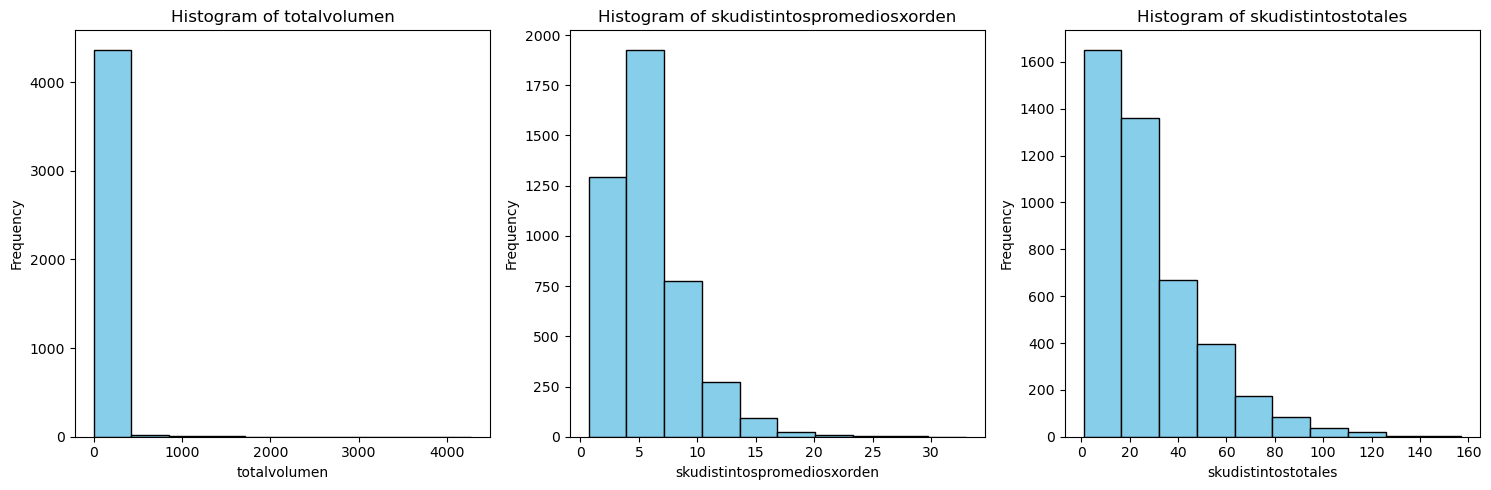

shape: (16, 2)
┌────────────┬────────────────────┐
│ volume_bin ┆ poc_distinct_count │
│ ---        ┆ ---                │
│ f64        ┆ u32                │
╞════════════╪════════════════════╡
│ 0.0        ┆ 4261               │
│ 100.0      ┆ 61                 │
│ 200.0      ┆ 28                 │
│ 300.0      ┆ 15                 │
│ 400.0      ┆ 7                  │
│ 500.0      ┆ 4                  │
│ 600.0      ┆ 5                  │
│ 700.0      ┆ 3                  │
│ 800.0      ┆ 3                  │
│ 900.0      ┆ 2                  │
│ 1000.0     ┆ 3                  │
│ 1100.0     ┆ 2                  │
│ 1200.0     ┆ 1                  │
│ 1300.0     ┆ 1                  │
│ 1600.0     ┆ 3                  │
│ 4200.0     ┆ 1                  │
└────────────┴────────────────────┘


In [19]:
# measures of central tendency for numerical data
print(atributes[numerical].describe())
plot_histograms(atributes, numerical)
# Contar los valores distintos de 'pocr' en bloques de 500 en la columna 'totalvolumen'
result = count_distinct_in_bins(atributes, volume_column="totalvolumen", column="poc", bin_size=100)
# Mostrar el resultado
print(result)

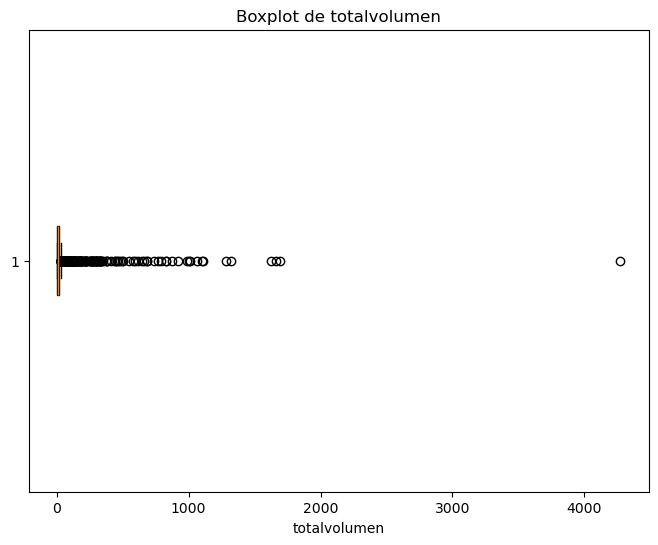

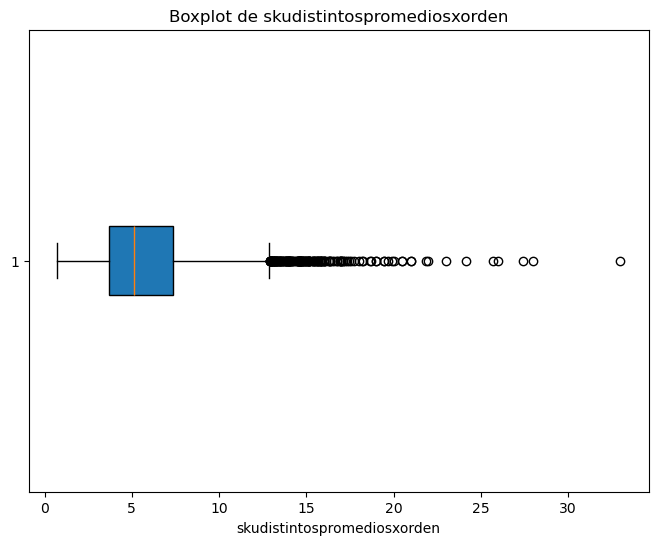

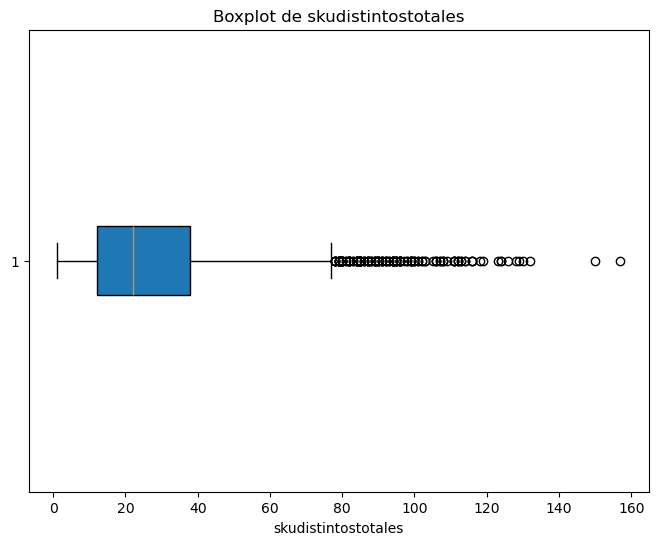

In [20]:
plot_boxplots(atributes, numerical)

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 4261.0       ┆ 4261.0                      ┆ 4261.0              │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 10.555502    ┆ 5.949519                    ┆ 27.481342           │
│ std        ┆ 14.581388    ┆ 3.193991                    ┆ 21.533846           │
│ min        ┆ 0.02124      ┆ 0.75                        ┆ 1.0                 │
│ 25%        ┆ 2.03756      ┆ 3.7143                      ┆ 12.0                │
│ 50%        ┆ 5.31534      ┆ 5.2                         ┆ 21.0                │
│ 

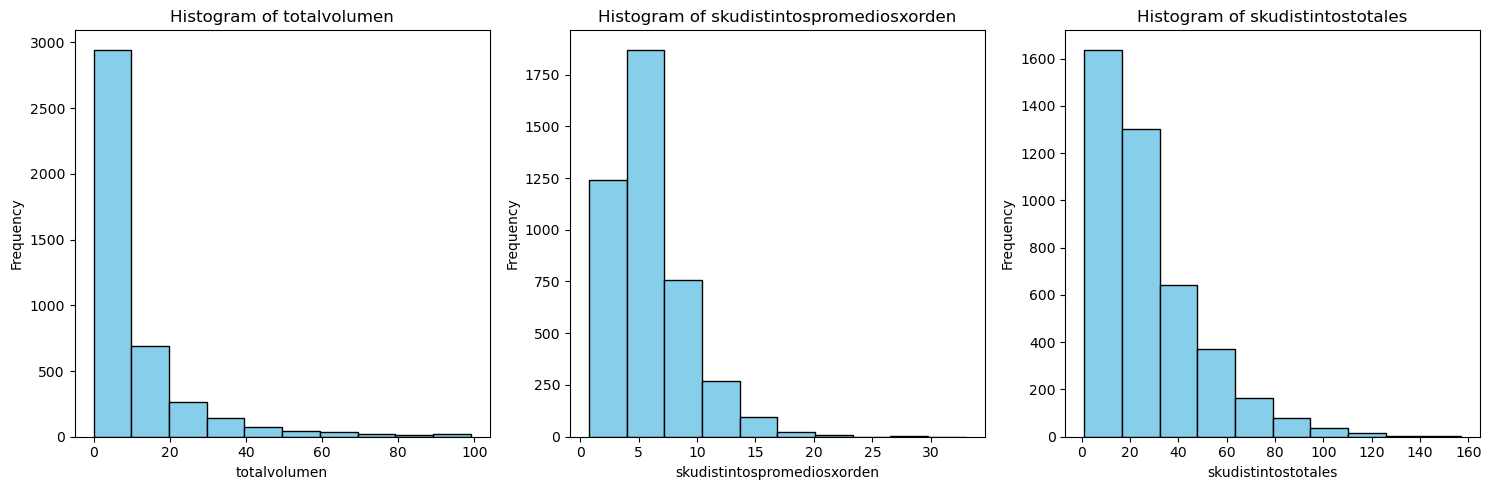

In [21]:
# Filtrar los resultados para mostrar solo aquellos clientes con volumen de compra menores o iguales a 100 (97% de los datos)
outliers = atributes.filter(pl.col("totalvolumen") > 100)
filtered_result = atributes.filter(pl.col("totalvolumen") <= 100)
print(filtered_result[numerical].describe())
plot_histograms(filtered_result, numerical)

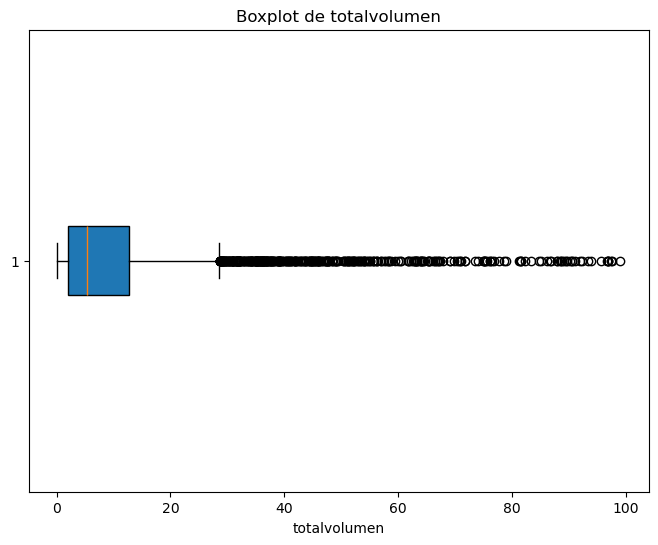

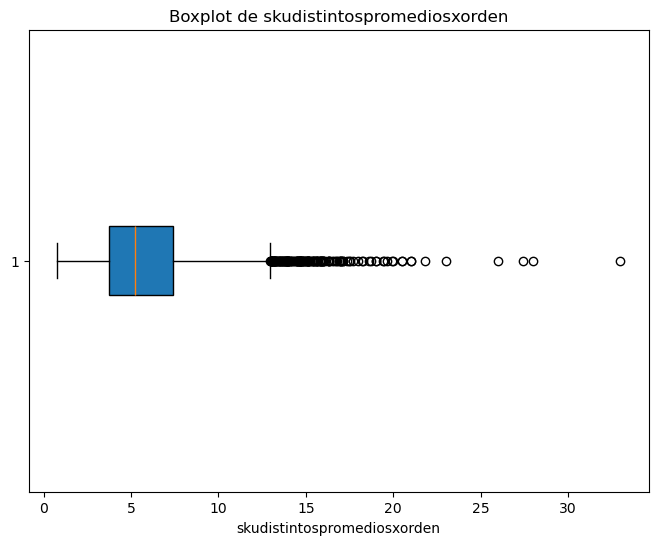

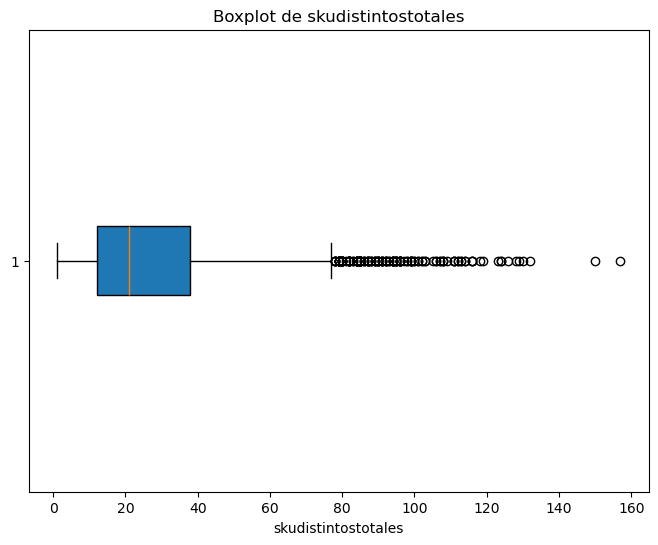

In [22]:
plot_boxplots(filtered_result, numerical)

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 139.0        ┆ 139.0                       ┆ 139.0               │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 381.454472   ┆ 4.731182                    ┆ 38.604317           │
│ std        ┆ 470.928405   ┆ 3.960411                    ┆ 22.200868           │
│ min        ┆ 100.71814    ┆ 0.7027                      ┆ 3.0                 │
│ 25%        ┆ 135.84414    ┆ 2.4831                      ┆ 24.0                │
│ 50%        ┆ 231.26044    ┆ 3.54                        ┆ 32.0                │
│ 

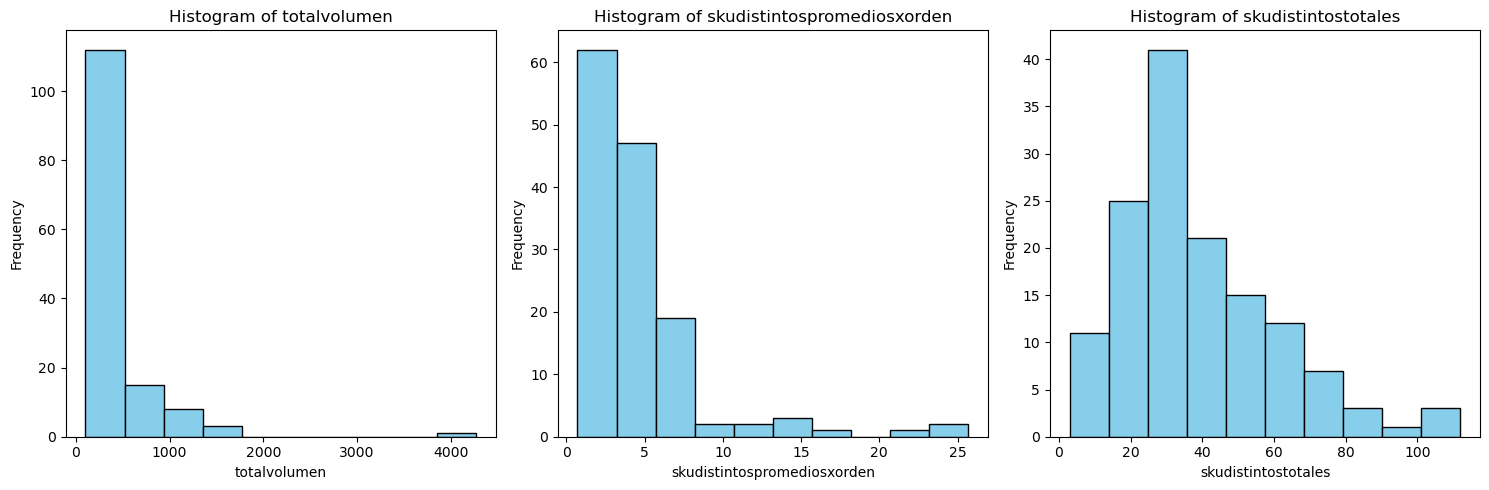

In [23]:
print(outliers[numerical].describe())
plot_histograms(outliers, numerical)

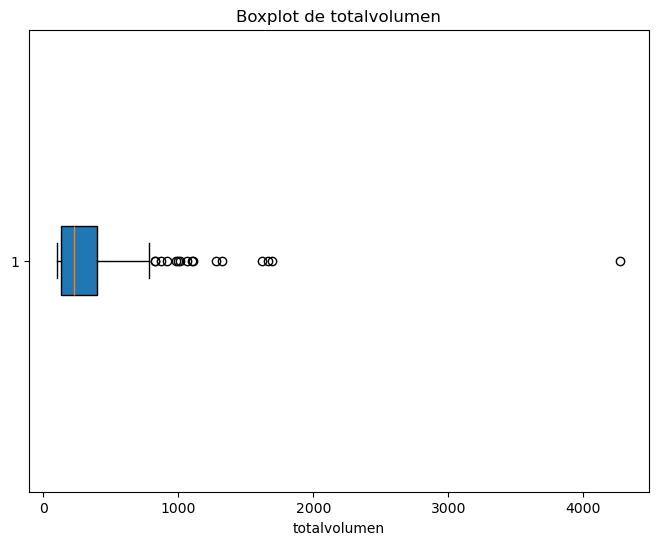

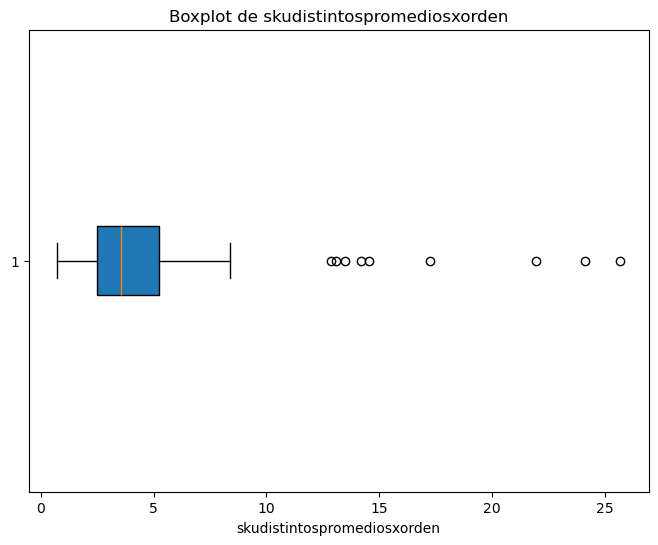

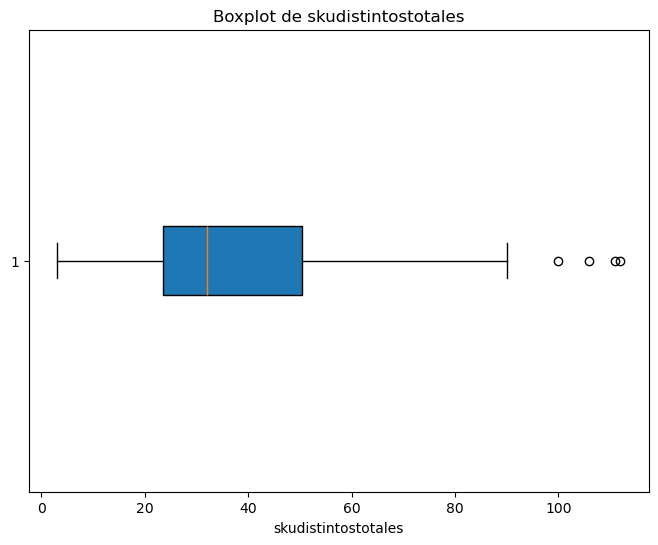

In [24]:
plot_boxplots(outliers, numerical)


### Datos de transacciones de los clientes

#### Calidad de los datos:
* Revisar valores nulos
* Revisar valores fuera de rango
* Cuantificar outliers

Transformaciones y/o agregaciones:

* Convertir invoice_date a un formato de fecha: Aunque actualmente es un entero,convertiremos la variable invoice_date a un tipo de dato de fecha para realizar análisis temporales.

* Crear dataset aparte con agrupación por cliente: Dado que estamos interesados en el comportamiento de compra de los clientes, vamos a agrupar los datos por account_id para analizar patrones de compra individuales.

* Crear dataset aparte con agrupación por item: Dado que también estamos interesados en el comportamiento de compra sobre los items, vamos a agrupar los datos por sku_id para analizar patrones de compra que se dan en general para los items.

##### Calidad de los datos:
* Revisar valores nulos --> No hay valores nulos en este dataset
* Revisar valores fuera de rango --> no se identifican valores fuera de rango (ejemplo: cantidad de bultos comprados del producto negativos )
* Cuantificar outliers --> vemos que hay bastantes outliers en la cantidad de bultos por SKU que se compran, lo cual no ocurre cuando vemos los datos como canastas y calculamos la cantidad de sku por canasta.

In [25]:
check_null_values(transactions)

column,null_count,null_percentage
str,u32,f64
"""id""",0,0.0
"""account_id""",0,0.0
"""sku_id""",0,0.0
"""invoice_date""",0,0.0
"""order_id""",0,0.0
"""items_phys_cases""",0,0.0


In [26]:
transactions.head()

id,account_id,sku_id,invoice_date,order_id,items_phys_cases
i64,i64,i64,i64,str,f64
0,430606,7038,20220729,"""512-3880249-0""",100.0
1,323267,14933,20220729,"""512-3882307-0""",1.0
2,357825,21971,20220723,"""512-3852880-0""",8.0
3,444926,7038,20220805,"""512-3913163-0""",20.0
4,450771,7030,20220816,"""512-3957000-0""",5.0


shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 280828.0  │
│ null_count ┆ 0.0       │
│ mean       ┆ 3.967979  │
│ std        ┆ 18.842399 │
│ min        ┆ 0.083333  │
│ 25%        ┆ 1.0       │
│ 50%        ┆ 1.0       │
│ 75%        ┆ 2.0       │
│ max        ┆ 2000.0    │
└────────────┴───────────┘


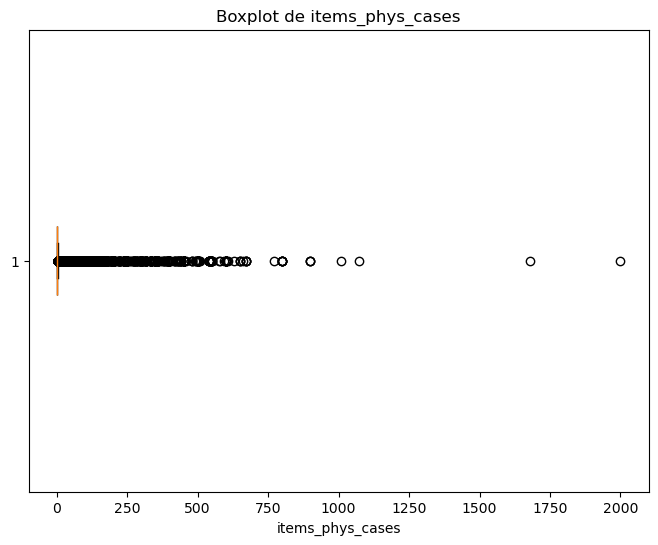

In [27]:
print(transactions['items_phys_cases'].describe())
plot_boxplots(transactions, ["items_phys_cases"])

shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 45552.0  │
│ null_count ┆ 0.0      │
│ mean       ┆ 6.164998 │
│ std        ┆ 4.756257 │
│ min        ┆ 1.0      │
│ 25%        ┆ 3.0      │
│ 50%        ┆ 5.0      │
│ 75%        ┆ 8.0      │
│ max        ┆ 55.0     │
└────────────┴──────────┘


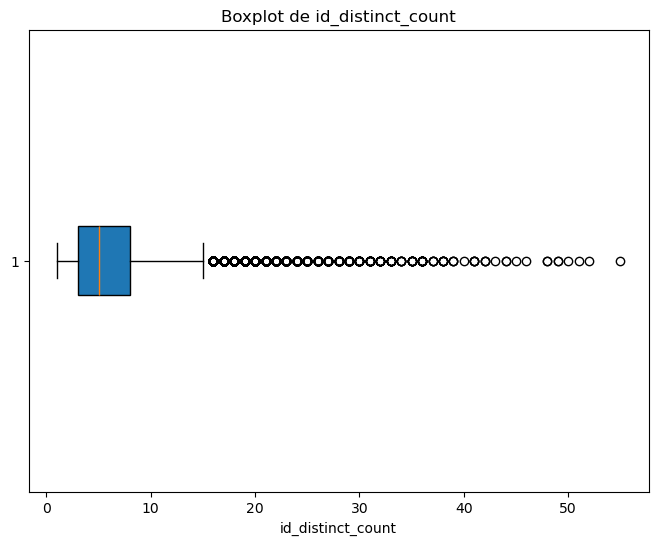

In [28]:
result = count_distinct_grouped_by(transactions, y_column="id", x_columns=['invoice_date','account_id',"order_id"],z_columns=['invoice_date','account_id',"order_id"])
print(result['id_distinct_count'].describe())
plot_boxplots(result, ["id_distinct_count"])

##### Transformaciones y/o agregaciones:

* Convertir invoice_date a un formato de fecha: Aunque actualmente es un entero,convertiremos la variable invoice_date a un tipo de dato de fecha para realizar análisis temporales.

* Crear dataset aparte de las canastas que es una agrupación por fecha-usuario-orden que contiene 1 o mas sku y que contiene 1 o más cantidades pedidas de cada sku

In [29]:
# Transform the f64 column to i64 (integer)
transactions = transactions.with_columns(
    pl.col("items_phys_cases").cast(pl.Int64).alias("items_phys_cases")
)

In [30]:
transactions = transactions.with_columns(pl.col("sku_id").cast(pl.Utf8))
transactions = transactions.with_columns(pl.col("order_id").cast(pl.Utf8))
transactions = transactions.with_columns(pl.col("account_id").cast(pl.Utf8))
transactions = transform_to_date(transactions, ['invoice_date'])
transactions.head()

id,account_id,sku_id,invoice_date,order_id,items_phys_cases
i64,str,str,date,str,i64
0,"""430606""","""7038""",2022-07-29,"""512-3880249-0""",100
1,"""323267""","""14933""",2022-07-29,"""512-3882307-0""",1
2,"""357825""","""21971""",2022-07-23,"""512-3852880-0""",8
3,"""444926""","""7038""",2022-08-05,"""512-3913163-0""",20
4,"""450771""","""7030""",2022-08-16,"""512-3957000-0""",5


In [31]:
import polars as pl

def process_transactions(
    df: pl.DataFrame,
    group_cols: list[str],
    list_col: str,
    sum_cols: list[str]
) -> pl.DataFrame:
    
    # Create the aggregation expressions
    agg_exprs = [
        pl.col(list_col).alias(list_col),
        pl.col(list_col).count().alias(f"{list_col}_count")
    ] + [pl.col(col).sum().alias(col) for col in sum_cols]
    
    # Perform the groupby and aggregation in one step
    result = df.group_by(group_cols).agg(agg_exprs)
    
    return result.sort('invoice_date')

# Now let's try to use the function
baskets = process_transactions(
    df=transactions,
    group_cols=['invoice_date','account_id','order_id'],
    list_col='sku_id',
    sum_cols=['items_phys_cases']
)
print(baskets .head())

shape: (5, 6)
┌──────────────┬────────────┬────────────────┬───────────────────┬──────────────┬──────────────────┐
│ invoice_date ┆ account_id ┆ order_id       ┆ sku_id            ┆ sku_id_count ┆ items_phys_cases │
│ ---          ┆ ---        ┆ ---            ┆ ---               ┆ ---          ┆ ---              │
│ date         ┆ str        ┆ str            ┆ list[str]         ┆ u32          ┆ i64              │
╞══════════════╪════════════╪════════════════╪═══════════════════╪══════════════╪══════════════════╡
│ 2022-05-24   ┆ 140565     ┆ 512-3605294-0  ┆ ["691", "16667",  ┆ 9            ┆ 10               │
│              ┆            ┆                ┆ … "21971"]        ┆              ┆                  │
│ 2022-05-24   ┆ 377860     ┆ 102-38958976-0 ┆ ["7651", "23902"] ┆ 2            ┆ 2                │
│ 2022-05-24   ┆ 75296      ┆ 512-3601848-0  ┆ ["19088",         ┆ 3            ┆ 5                │
│              ┆            ┆                ┆ "77676", "7038"]  ┆           

## EDA --> Preguntas a contestar

**Sobre las clientes**
* ¿A cúantos clientes se les debe hacer recomendación?
* ¿Cuánto compran los clientes?
* Si los categorizo por:
    * Segmento de negocio
    * Concentración
    * NSE
    * Segmento único
    * Canal
¿Hay diferencias significativas?
¿Hay relación entre los clientes de las distintas categorías?
  
* ¿Con qué frecuencia los clientes realizan compras?
* ¿Cómo varía la frecuencia de compra a lo largo del tiempo?
* ¿Cuál es la cantidad de clientes que compran por item disponible para recomendación?
* ¿Cuál es el tiempo entre compras consecutivas de los cliente?
* ¿Cuál es la frecuencia de compra por cliente?
* ¿Existen clientes con comportamiento de compra repetitivo? ¿Quienes?
* ¿Cómo se comportan las diferentes cohortes de clientes a lo largo del tiempo?
* ¿Cómo evolucionan las ventas en diferentes cohortes?


**Sobre las canastas**
* ¿Cúanto es el gasto por canasta?
* ¿Cuantas canastas compran los clientes?
* ¿Cuántos items compran por canasta?



**Sobre los items**
* ¿Cuál es la cantidad total de items disponibles para recomendación?
* ¿Cuál es la cantidad de items por canasta?
* ¿Cuál es la cantidad de items por cliente disponible para recomendación?

**Anomalias**

* ¿Existen anomalías o irregularidades en la distribución de fechas de compra?
* ¿Cómo afectan estas anomalías al negocio?

### Análisis sobre los clientes 

#### ¿A cúantos clientes se les debe hacer recomendación?

R: 4400 clientes

* ¿Cuánto compran los clientes?

R: Compran, en promedio, 5.9 productos distintos por orden en un periodo aproximado de 3 meses, el 50% compra 22 o más productos y 5.6 o más litros de cerveza. Es importante recalcar que el 75% compra hasta 14 litros, pero hay clientes que llegan a comprar 4274 litros en este periodo

In [32]:
# measures of central tendency for numerical data
atributes[numerical].describe()

statistic,totalvolumen,skudistintospromediosxorden,skudistintostotales
str,f64,f64,f64
"""count""",4400.0,4400.0,4400.0
"""null_count""",0.0,0.0,0.0
"""mean""",22.272537,5.911031,27.832727
"""std""",106.642437,3.227491,21.640289
"""min""",0.02124,0.7027,1.0
"""25%""",2.12124,3.6667,12.0
"""50%""",5.6011,5.1429,22.0
"""75%""",13.95536,7.3542,38.0
"""max""",4274.44416,33.0,157.0


#### ¿Hay diferencias significativas en la categoría? Si los categorizo por:
* Segmento de negocio : aunque es homogenea, es importante notar que solo un 21% de los clientes tiene un nivel de uso bajo o nulo de la aplicación (potencialmente descartable para el MVP)
* Concentración : No es homogenea y la concentración de otros negocios de otra índole a 150mts2 es de un 90% su agrupamos los niveles alto y medio 
* NSE : No es homogenea y es importante notar que un 23% está sin datos
* Segmento único: No es homogenea y los clientes con capacidad media de compra son el 61%, mientras que el 20% es de baja y el 17% es de alta, el resto no tiene datos
* Canal : el 88% de los clientes pertenece al canal tradidicional, Kioscos o Maxikioscos  o Comida

¿Estas categorías son independientes entre si?
No, las categorías no son independientes entre si

Adicionalmente, vemos que no hay diferencias significativas en las relaciones encontradas cuando se observa solo los datos que tienen volúmenes altos

In [33]:
results = count_unique_values(atributes, categorical)
results

{'bussinesssegment': 4, 'concentracion': 3, 'segmentounico': 5, 'canal': 11}

In [34]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["bussinesssegment"],z_columns=["poc_percentage"])
result

bussinesssegment,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""PowerUsage""",1213,4400,27.568182
"""HighUsage""",1213,4400,27.568182
"""MediumUsage""",1050,4400,23.863636
"""MinimalUsage""",924,4400,21.0


In [35]:
count_distinct_grouped_by(outliers, y_column="poc", x_columns=["bussinesssegment"],z_columns=["poc_percentage"])

bussinesssegment,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""HighUsage""",45,139,32.374101
"""PowerUsage""",39,139,28.057554
"""MediumUsage""",38,139,27.338129
"""MinimalUsage""",17,139,12.230216


In [36]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["concentracion"],z_columns=["poc_percentage"])
result

concentracion,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Alto""",2319,4400,52.704545
"""Medio""",1954,4400,44.409091
"""Bajo""",127,4400,2.886364


In [37]:
count_distinct_grouped_by(outliers, y_column="poc", x_columns=["concentracion"],z_columns=["poc_percentage"])

concentracion,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Medio""",75,139,53.956835
"""Alto""",60,139,43.165468
"""Bajo""",4,139,2.877698


In [38]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["segmentounico"],z_columns=["poc_percentage"])
result

segmentounico,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""4.Activos""",1934,4400,43.954545
"""1.Inactivos""",888,4400,20.181818
"""2.Masivos""",820,4400,18.636364
"""5.Select""",631,4400,14.340909
"""3.Potenciales""",127,4400,2.886364


In [39]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(outliers, y_column="poc", x_columns=["segmentounico"],z_columns=["poc_percentage"])
result

segmentounico,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""5.Select""",71,139,51.079137
"""4.Activos""",50,139,35.971223
"""2.Masivos""",13,139,9.352518
"""3.Potenciales""",5,139,3.597122


In [40]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["canal"],z_columns=["poc_percentage"])
result

canal,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Tradicional""",2665,4400,60.568182
"""Kioscos/Maxikioscos""",821,4400,18.659091
"""COMIDA""",415,4400,9.431818
"""Autoservicio""",186,4400,4.227273
"""BEBIDA""",101,4400,2.295455
"""ENTRETENIMIENTO""",79,4400,1.795455
"""Mayorista""",53,4400,1.204545
"""Instituciones""",43,4400,0.977273
"""KA Minoristas""",18,4400,0.409091


In [41]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(outliers, y_column="poc", x_columns=["canal"],z_columns=["poc_percentage"])
result

canal,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Tradicional""",59,139,42.446043
"""Mayorista""",33,139,23.741007
"""Autoservicio""",13,139,9.352518
"""Kioscos/Maxikioscos""",12,139,8.633094
"""COMIDA""",10,139,7.194245
"""BEBIDA""",6,139,4.316547
"""KA Minoristas""",3,139,2.158273
"""Instituciones""",2,139,1.438849
"""ENTRETENIMIENTO""",1,139,0.719424


In [42]:
# Obtener la matriz de resultados
chi2_results_matrix = chi2_matrix(chi2_test, atributes, categorical, confidence_level=0.99)
chi2_results_matrix

,bussinesssegment,concentracion,segmentounico,canal
bussinesssegment,False,True,True,True
concentracion,True,False,True,True
segmentounico,True,True,False,True
canal,True,True,True,False


#### ¿Con qué frecuencia los clientes realizan compras?

#### ¿Cuál es la cantidad de clientes que compran por item disponible para recomendación?

In [43]:
baskets.head()

invoice_date,account_id,order_id,sku_id,sku_id_count,items_phys_cases
date,str,str,list[str],u32,i64
2022-05-24,"""140565""","""512-3605294-0""","[""691"", ""16667"", … ""21971""]",9,10
2022-05-24,"""377860""","""102-38958976-0""","[""7651"", ""23902""]",2,2
2022-05-24,"""75296""","""512-3601848-0""","[""19088"", ""77676"", ""7038""]",3,5
2022-05-24,"""419425""","""512-3602490-0""","[""24118"", ""7651"", … ""7038""]",11,20
2022-05-24,"""74556""","""102-38960010-0""","[""7038"", ""25030"", ""7026""]",3,5


#### ¿Cuál es la cantidad de clientes que compran por item disponible para recomendación?
* ¿Cuál es el tiempo entre compras consecutivas de los cliente?
* ¿Cuál es la frecuencia de compra por cliente?
* ¿Existen clientes con comportamiento de compra repetitivo? ¿Quienes?
* ¿Cómo se comportan las diferentes cohortes de clientes a lo largo del tiempo?
* ¿Cómo evolucionan las ventas en diferentes cohortes?

## Modelado

Se implementarán los algoritmos TIFUKNN y , pues son los dos algoritmos que combinan de forma adecuada la simplicidad con buena performance en los benchmark públicos según la literatura

El proceso es el siguiente:

1.- Construir una matriz que capture la frecuencia de compra de cada sku_id por cliente (account_id).

2.- Calcula la similitud entre los SKU utilizando la similitud coseno basada en las frecuencias de compra.

3.- Utilizar la similitud calculada para recomendar los SKU más similares basados en la frecuencia y recencia de compra.

In [46]:
item_user_matrix = build_matrix_item_user(transactions, col_sku="sku_id", col_account="account_id")
col_account="account_id"
users = transactions[col_account].unique().to_list()
item_user_vectors, items = matrix_to_vector(item_user_matrix, users, col_account="account_id")
# Calcular la similitud coseno entre los ítems
item_similarity = cosine_similarity(item_user_vectors)

In [49]:
# 4.1. Obtener los índices de los ítems similares
def obtener_indice_item(item, items):
    return items.index(item)

def obtener_items_similares(item, item_similarity, items, k):
    idx = obtener_indice_item(item, items)
    sorted_indices = np.argsort(item_similarity[idx])[::-1]
    return list(map(lambda i: items[i], sorted_indices[:k]))

# 4.2. Recomendar ítems similares basados en la frecuencia de compra
def recomendar_items(item, freq, item_similarity, items, k):
    similares = obtener_items_similares(item, item_similarity, items, k)
    return list(map(lambda similar_item: (similar_item, item_similarity[obtener_indice_item(item, items), obtener_indice_item(similar_item, items)] * freq), similares))

# 4.3. Predecir la próxima canasta usando TIFUKNN
def predecir_proxima_canasta(historial_usuario, item_similarity, items, k=3):
    # 4.3.1. Crear la lista de todos los ítems comprados por el usuario
    todos_items = reduce(lambda acc, basket: acc + basket, historial_usuario, [])
    
    # 4.3.2. Calcular la frecuencia de compra de cada ítem
    item_freq = Counter(todos_items)
    
    # 4.3.3. Generar recomendaciones para cada ítem en el historial del usuario
    recomendaciones = reduce(
        lambda acc, item_freq_pair: acc + recomendar_items(item_freq_pair[0], item_freq_pair[1], item_similarity, items, k),
        item_freq.items(),
        []
    )
    
    # 4.3.4. Ordenar las recomendaciones por puntuación y devolver los mejores K ítems
    recomendaciones_ordenadas = sorted(recomendaciones, key=lambda x: x[1], reverse=True)
    return list(map(lambda x: x[0], recomendaciones_ordenadas[:k]))

# Ejemplo de uso
historial_usuario = transactions.filter(pl.col('account_id') == '419425')['sku_id'].to_list()
proxima_canasta = predecir_proxima_canasta(historial_usuario, item_similarity, items, k=3)
print("Recomendaciones para la próxima canasta:", proxima_canasta)


TypeError: can only concatenate list (not "str") to list